# Adding External Variables to our Model

#### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Statistical Modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
# Statistical Modeling API
import statsmodels.api as sm

# Iterators Optimizer
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

# Warnings
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

#### Loading Data

In [5]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


Text(0.5, 1.0, 'Real Gross Domestic Product (GDP):  From 1959-2009')

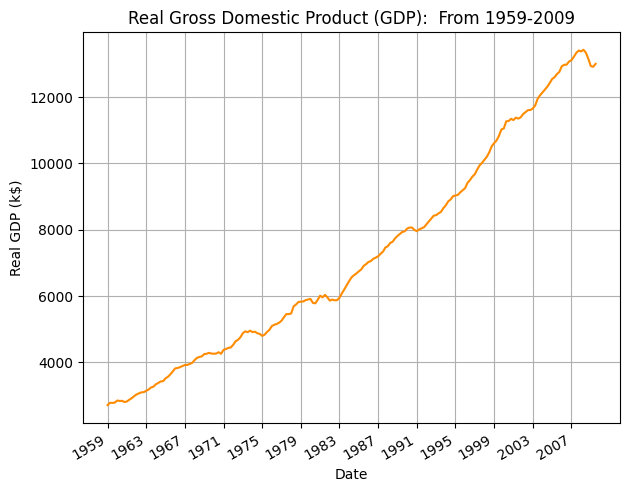

In [6]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'], color='darkorange')
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')
ax.grid(True)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Real Gross Domestic Product (GDP):  From 1959-2009')

##### Checking Exogenous & Chosen Endogenous Variables

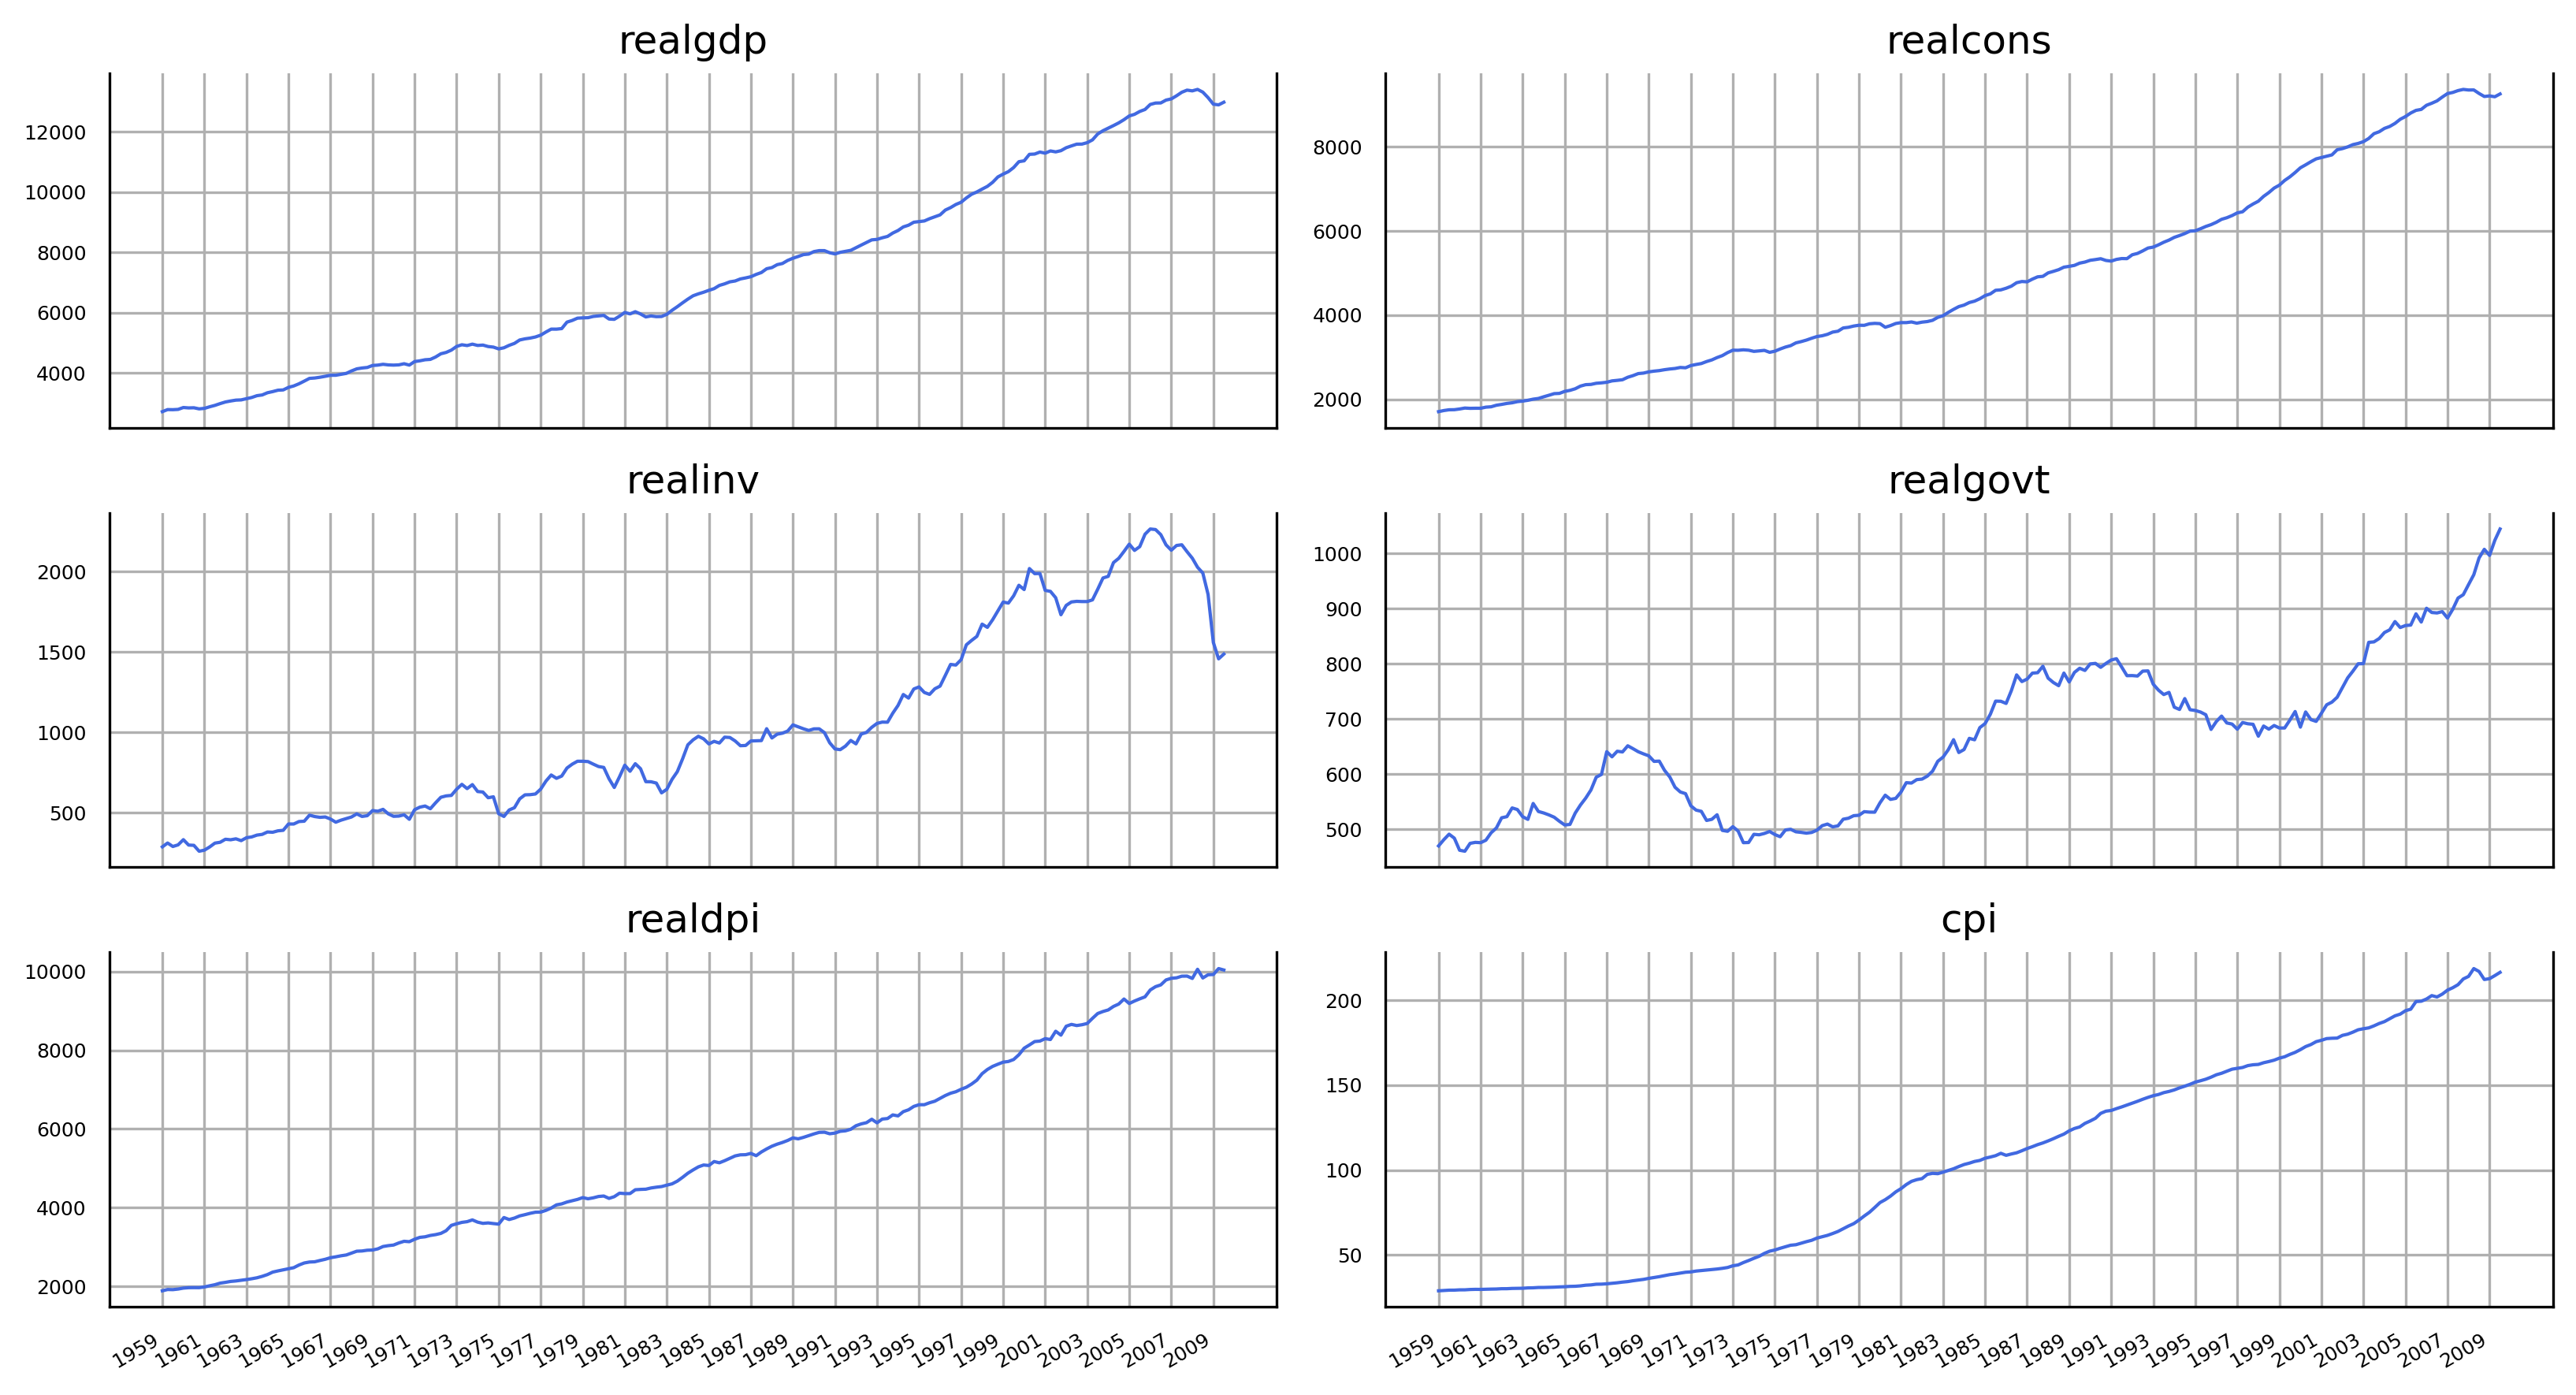

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='royalblue', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.grid(True)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

### Forecasting GDP using SARIMAX Model

##### Defining Target and Exogenous variables

In [10]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

##### Dickey-Fuller 

In [11]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647095
p-value: 0.9982455372335032


##### Applying 1st Order Differencing Procedure

In [12]:
# Differencing Target
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658102
p-value: 3.327882187668259e-08


##### Optimized SARIMAX Function

In [19]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

##### Range of Possible Orders

In [20]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
# Frequency (m)
s = 4

In [21]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

##### Training Target & Exogenous Variables

In [22]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.840942
1,"(3, 3, 1, 0)",1744.964600
2,"(3, 3, 0, 1)",1744.996594
3,"(2, 2, 0, 0)",1745.432304
4,"(2, 2, 0, 1)",1745.806696
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


##### Model Selection & Summary

In [23]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.420
Date:                Thu, 29 Feb 2024   AIC                           1742.841
Time:                        11:23:23   BIC                           1782.361
Sample:                             0   HQIC                          1758.836
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9663      0.045     21.625      0.000       0.879       1.054
realinv        1.0136      0.033     30.862      0.000       0.949       1.078
realgovt       0.7280      0.127      5.737      0.0

##### Model Diagnose

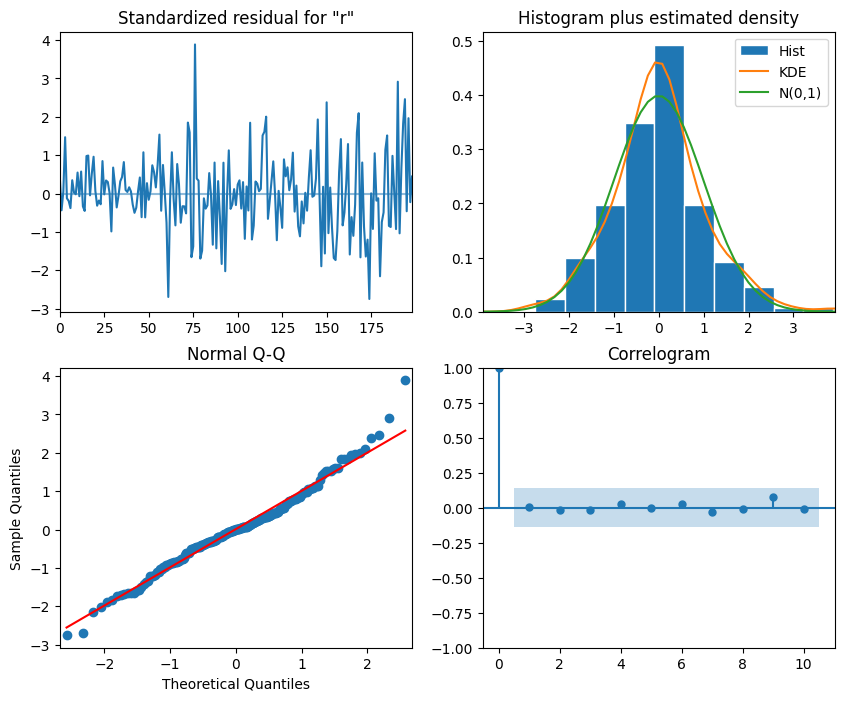

In [24]:
best_model_fit.plot_diagnostics(figsize=(10,8));

##### Applying LJung-Box Test

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Running the Ljung-Box test on the residuals
residuals = best_model_fit.resid
results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))

# Accessing the p-values from the results dictionary
pvalues = results['lb_pvalue']

print(pvalues)

1     0.777817
2     0.900246
3     0.975047
4     0.881841
5     0.946839
6     0.976970
7     0.985605
8     0.994104
9     0.994484
10    0.997738
Name: lb_pvalue, dtype: float64


#### Predicting Next Time Step Multiple Times

##### Defining Rolling Forecast Function

In [26]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [27]:
# Train set
target_train = target[:196]
# Test set
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.064769
197,13415.266,13366.865,13373.510371
198,13324.600,13415.266,13378.828416
199,13141.920,13324.600,13327.778290
200,12925.410,13141.920,13133.833069
201,12901.504,12925.410,12887.024689
202,12990.341,12901.504,12873.797047


##### Mean Absolute Percent Error Function

In [28]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7035630924311178


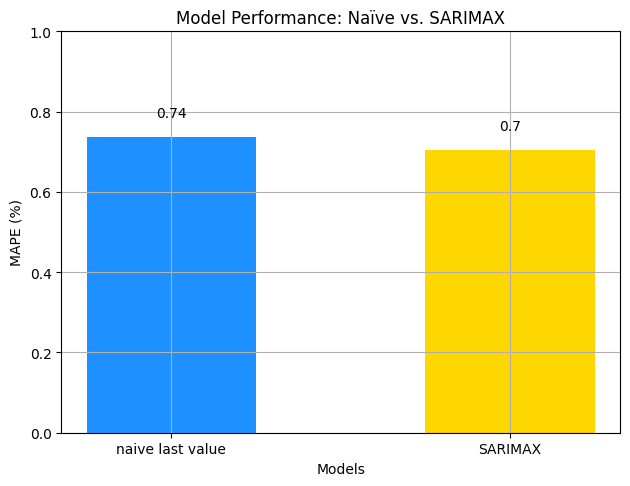

In [36]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.5, color=['dodgerblue', 'gold'])
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)
ax.grid(True)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.title('Model Performance: Naïve vs. SARIMAX')
plt.show()